In [9]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime
import xray as xr
import os 
from tqdm import tqdm

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [2]:
ddir = '/data/scratch/rpa/paul_holland_model/paul'

ds = xr.open_dataset(os.path.join(ddir, 'grid.glob.nc'))

for fname in ['state2D-fixed.nc', 'stateExf-fixed.nc',
              'stateTheta-fixed.nc', 'stateSalt-fixed.nc']:
    ds_new = xr.open_dataset(os.path.join(ddir, fname))
    # check if we need to select the top point of a 3D dataset
    if 'DEPTH' in ds_new:
        ds_new = ds_new.sel(DEPTH=5.0)
        ds_new = ds_new.drop('DEPTH')
    # state is 32 bit while grid is 64 bit
    # we can make merging easier by giving them the same coords
    ds_new['X'] = ds.X
    ds_new['Y'] = ds.Y
    ds = ds.merge(ds_new)
ds

<xray.Dataset>
Dimensions:   (TIME: 493, X: 1440, Xp1: 1440, Y: 640, Yp1: 640, Z: 50, Zl: 50, Zp1: 51, Zu: 50)
Coordinates:
  * X         (X) float64 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * Y         (Y) float64 -85.91 -85.89 -85.88 -85.86 -85.84 -85.82 -85.8 ...
  * Xp1       (Xp1) float64 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 ...
  * Yp1       (Yp1) float64 -85.92 -85.9 -85.88 -85.87 -85.85 -85.83 -85.81 ...
  * Z         (Z) float64 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.0 ...
  * Zp1       (Zp1) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * Zu        (Zu) float64 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 -80.01 ...
  * Zl        (Zl) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * TIME      (TIME) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    Depth     (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dxC       (Y, Xp1) float64 1.982e+03 1.982e+03 1.982e+03 1.982e+03 ...
  

In [3]:
mask = (ds.HFacC[0]==0.0)

In [4]:
deltaT = 900
diag_freq = 432000 # 5-day
diag_prefix= 'DiagIce-5day'

diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = np.round(np.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']



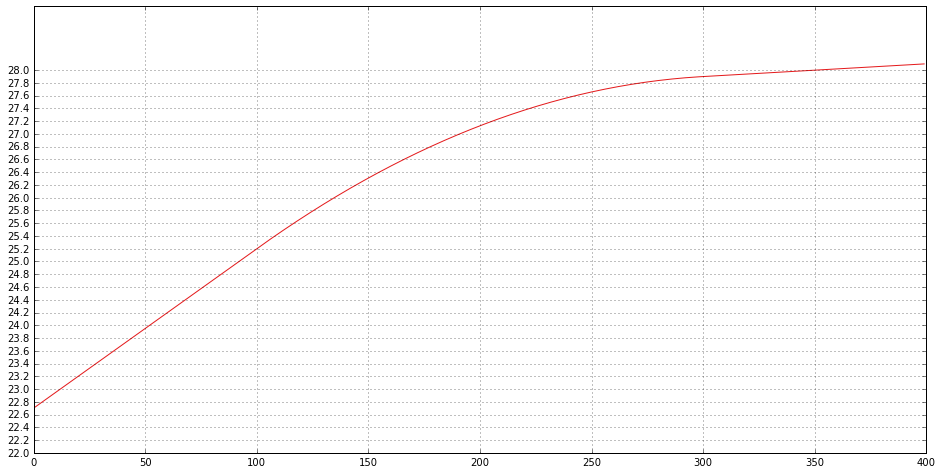

In [6]:
drho1 = 0.002
drho2 = 0.025
#drho3 = 0.025

rho0 = 1028.1

drho = np.hstack([
        drho1 * np.ones(100),
        np.linspace(drho1, drho2, 200),
        drho2 * np.ones(100),
#        np.linspace(drho2, drho3 ,100),
#        drho3 * np.ones(100),
])
rholevs = (rho0 - np.cumsum(drho))[::-1]
plt.plot(rholevs-1000, '-')
plt.yticks(np.arange(22,28.1,0.2))
plt.grid()

In [53]:
rholevs.max()

1028.098

In [7]:
salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

#Nrho = 300
#rholevs = np.linspace(1022.,1028.0,Nrho+1)

Nrho = len(rholevs)-1

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [16]:
import quick_transformation as qt
reload(qt)

<module 'quick_transformation' from 'quick_transformation.py'>

In [18]:
Nt = len(ds.TIME)
transformation = np.zeros((Nt, len(fw_flux_types)+1, Nrho), 'f8')
fw_in_dens_coords = np.zeros((Nt, len(fw_flux_types), Nrho), 'f8')

#for nmon, niter in tqdm(enumerate(diag_iters)):
for n in tqdm(range(Nt)):

    # just this timestep
    d = ds.isel(TIME=n)

    rho, drhodt, drhods = eos.state_surface(d['THETA'].values, d['SALT'].values)

    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': np.ma.masked_array(d['SIempmr'], mask),
      'AI_plus_AO': -np.ma.masked_array(d['SIatmFW'], mask),
      'SIsnPrcp':  -np.ma.masked_array(d['SIsnPrcp'], mask)
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = np.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    fw_fluxes['IO_melt'] = np.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    # has the same units as SFLUX
    salt = d['SALT']
    
    dens_flux_S = [ drhods * fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                    for k in fw_flux_types ]
 
    # paul didn't save these
    #dens_flux_S.append( drhods * d['WSLTMASS'] )
    
    fw_flux = [fw_fluxes[k].filled(0.) for k in fw_flux_types]
    
    # pault didn't save this 
    #tflux = np.ma.masked_array(d['TFLUX'], m.mask[0]) 
    tflux = np.ma.masked_array(d['oceQnet'], mask)
    dens_flux_T = [drhodt * fluxfac_T * tflux, ]
    
    # paul didn't save these
    #dens_flux_T.append( drhodt * d['WTHMASS'])
    
    transformation[n] = qt.surface_transformation_rate(
                        ds.rA, rho, rholevs,
                         fields=(dens_flux_T + dens_flux_S))
    
    fw_in_dens_coords[n] = qt.surface_transformation_rate(
                        ds.rA, rho, rholevs, fields=fw_flux)

    

In [20]:
print transformation.shape
transformation_labels = (['heat_flux'] +
    ['salt_' + fwft for fwft in fw_flux_types] )
print transformation_labels
print len(transformation_labels)

# just turn it all to an xray dataset
deltaTclock = 900
time = ds.TIME.values
sigma0 = rholevs[1:]-1000.
ds_out = xr.Dataset(coords={'sigma0': sigma0, 'time': time})

for n in range(len(transformation_labels)):
    ds_out[transformation_labels[n]] = xr.DataArray(transformation[:,n],
                        coords=[time, sigma0], dims=('time', 'sigma0'))

#ds_out.to_netcdf('../data/wmt_surface_PAUL.nc')

(493, 8, 399)
['heat_flux', 'salt_IO_plus_AO', 'salt_AI_plus_AO', 'salt_AI', 'salt_AO', 'salt_IO', 'salt_IO_brine', 'salt_IO_melt']
8


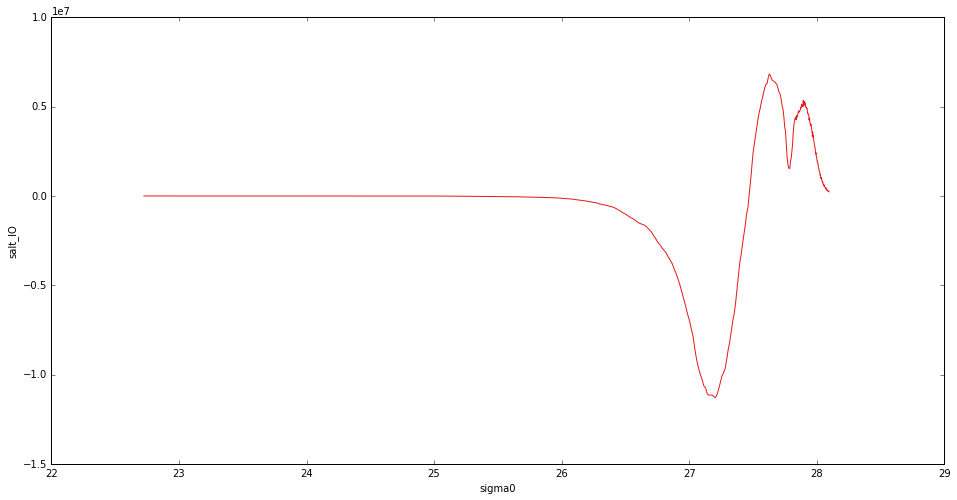

In [24]:
ds_out.salt_IO.mean(dim='time').plot()

In [56]:
# density-weighted ice concentration
ice_conc_rho = np.zeros((Nt, Nrho), 'f8')
heff_rho = np.zeros((Nt, Nrho), 'f8')
outcrop_area = np.zeros((Nt, Nrho), 'f8')
for nmon in tqdm(range(Nt)):
    
    d = ds.isel(TIME=nmon)
    SIarea = d['SIarea'].values
    heff = d['SIheff'].values
    
    rho, drhodt, drhods = eos.state_surface(d['THETA'].values, d['SALT'].values)
    
    ice_conc_rho[nmon], outcrop_area[nmon] = average_field_in_rho(ds.rA, rho, rholevs, SIarea)
    heff_rho[nmon], outcrop_area[nmon] = average_field_in_rho(ds.rA, rho, rholevs, heff, avg=False)
    

In [57]:
fw_in_dens_coords.shape

(493, 7, 399)

In [60]:
ds_fw = xr.Dataset(coords={'sigma0': sigma0, 'time': time})

for n in range(len(fw_flux_types)):
    ds_fw[fw_flux_types[n]] = xr.DataArray(fw_in_dens_coords[:,n],
                        coords=[time, sigma0], dims=('time', 'sigma0'))

ds_fw['drho'] = xr.DataArray(drho, coords=[sigma0], dims=['sigma0'])
    
ds_fw.to_netcdf('../data/fw_flux_dens_coords_PAUL.nc')

ValueError: conflicting sizes for dimension 'sigma0': length 400 on <this-array> and length 399 on 'sigma0'

In [61]:
ds_ice = xr.Dataset(coords={'sigma0': sigma0, 'time': time})
ds_ice['heff'] = xr.DataArray(heff_rho, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice['concentration'] = xr.DataArray(ice_conc_rho, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice['outcrop_area'] = xr.DataArray(outcrop_area, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice.to_netcdf('../data/ice_in_rho_space_PAUL.nc')
ds_ice

<xray.Dataset>
Dimensions:        (sigma0: 399, time: 493)
Coordinates:
  * sigma0         (sigma0) float64 22.72 22.75 22.77 22.8 22.82 22.85 22.87 ...
  * time           (time) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    heff           (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    concentration  (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    outcrop_area   (time, sigma0) float64 4.689e+09 7.822e+09 7.859e+09 ...

In [52]:
# load extra water mass transformation data
wmt_full = np.load('../data/wmt_upper_470m.npz')
labels_salt = ['surfflux', 'linfs', 'adv', 'hdiff', 'kpp', 'tot', 'vdiff']
labels_heat = ['surfflux', 'linfs', 'adv', 'kpp', 'vdiff', 'sw', 'tot', 'hdiff']
wmt_salt = wmt_full['wmt_salt'] 
wmt_heat = wmt_full['wmt_heat'] 
wmt_salt_mean = wmt_salt.mean(axis=0)
wmt_heat_mean = wmt_heat.mean(axis=0)


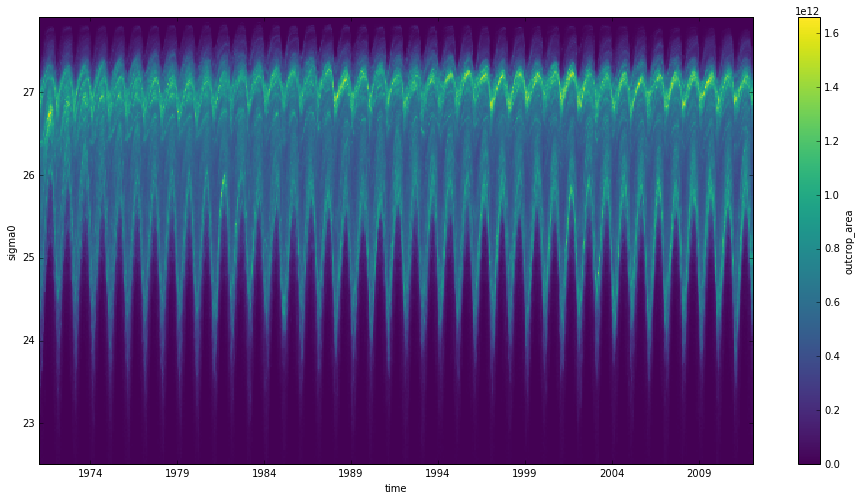

In [46]:
ds_ice.outcrop_area.T.plot()

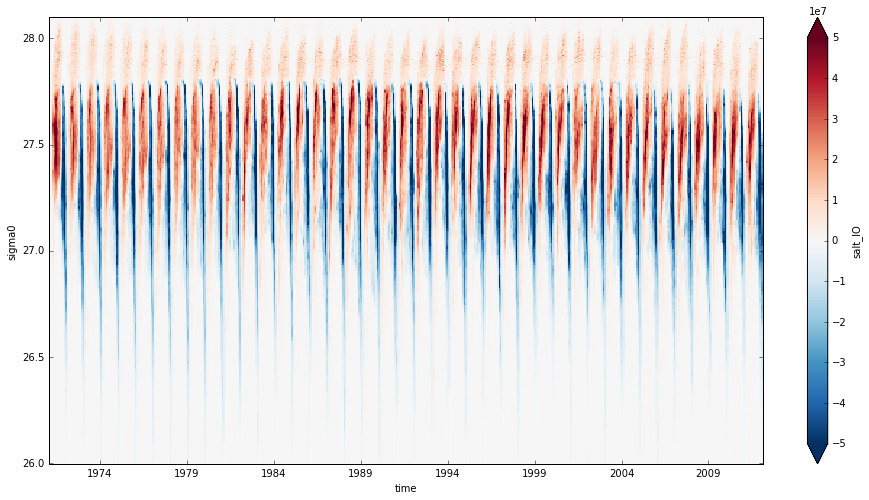

In [64]:
ds_out.salt_IO.sel(sigma0=slice(26,28.1)).T.plot(vmin=-5e7,vmax=5e7, cmap='RdBu_r')

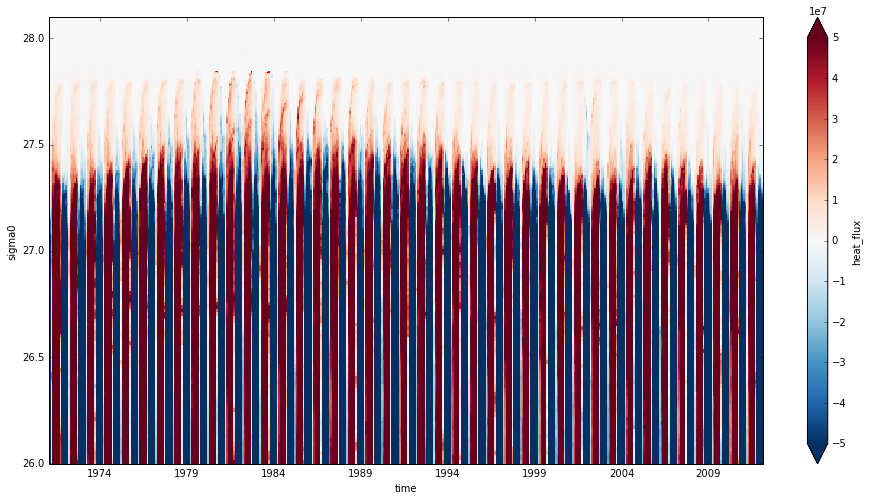

In [65]:
ds_out.heat_flux.sel(sigma0=slice(26,28.1)).T.plot(vmin=-5e7,vmax=5e7, cmap='RdBu_r')

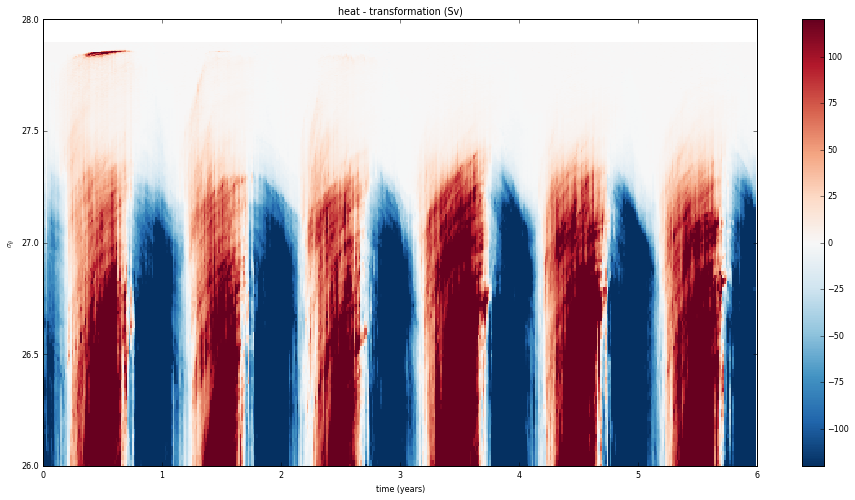

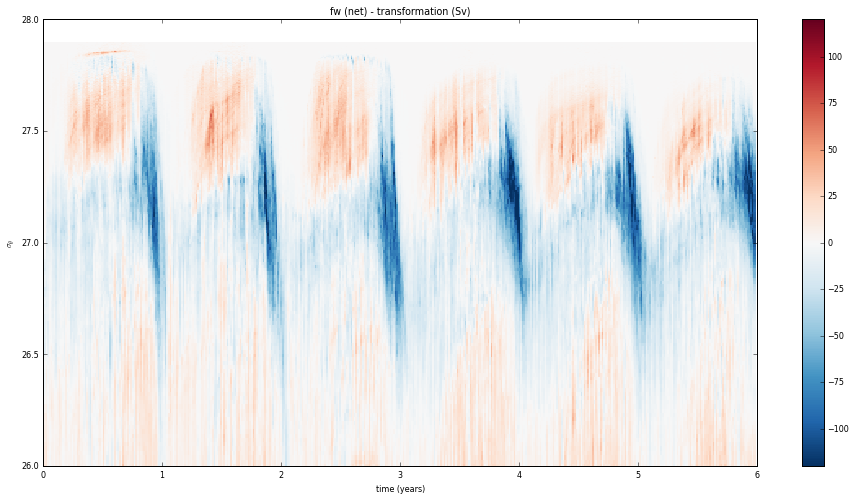

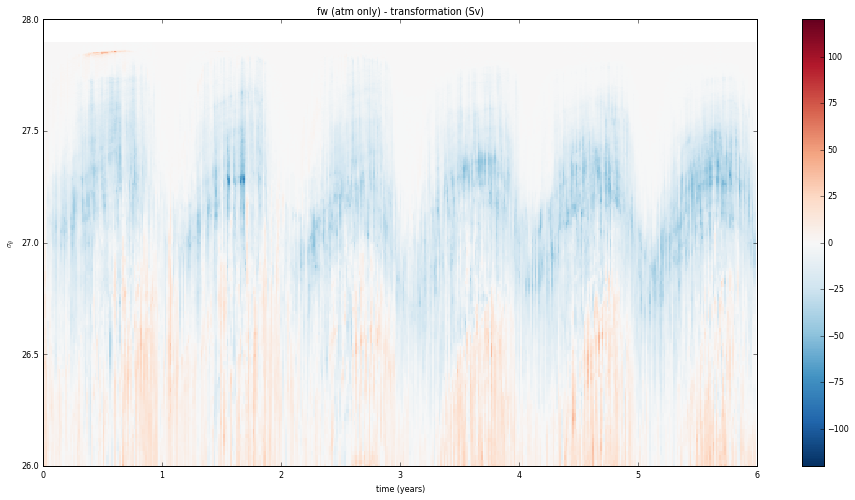

In [67]:
rl = rholevs[1:]-1000
time = np.arange(Nt)*5/365.

for n, tit in enumerate(['heat', 'fw (net)', 'fw (atm only)']):
    plt.figure()
    plt.pcolormesh(time, rl, transformation_monthy[:,n].T / 1e6, cmap='RdBu_r')
    plt.clim([-120,120])
    plt.ylim([26,28])
    plt.ylabel(r'$\sigma_\theta$')
    plt.xlabel('time (years)')
    plt.title(tit + ' - transformation (Sv)')
    plt.colorbar()

In [26]:
drho.shape

(399,)

In [27]:
fw_in_dens_coords.shape

(438, 7, 399)